# TODO 

- Special keys treatment 
- user identification 
- improve logger (possibility to name the csv and to stop the app without restarting the kernel)
- 5 samples for each profile 
- Similarity measures (std, classification, nearest neighbor)

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
from os import listdir
from os.path import isfile, join
import os
import math
import matplotlib.pyplot as plt
import string
import matplotlib
import matplotlib.path as path_bis
import matplotlib.patches as patches
import plotly.graph_objects as go


# Data import from keylogger

In [116]:
#file_path = 'keylog.txt'
path_merged = "input_data_merged/"
path_preprocessed_merged = "preprocessed_input_data_merged/"
columns = ['Timestamp', 'Key', 'Action']
columns_bis = ['Timestamp', 'Key', 'Action', 'Shift']
#dataframe = pd.read_csv(file_path, sep=";", names=columns, encoding = "ISO-8859-1")
#display(dataframe)

# Preprocessing

In the event that a key is pressed for a 'long time' (at least 2 consecutive row with the same 'Key' value and 'Action' = press), we only keep the first pressed
<br>We also create some columns for specific keys like Shift, Alt, Win, Ctrl

In [112]:
path = 'input_data/'
last_elements = {}
user_list = files = [os.path.splitext(filename)[0] for filename in listdir(path)]
for i in range(0,len(user_list),5):
    all_filenames = []
    Ts_last_elems = []
    user_name = user_list[i].split('_')[0]
    for j in range(1, 6):    
        all_filenames = np.append(all_filenames, [path+user_name+'_'+str(j)+'.csv'])
        tmp = pd.read_csv(path+user_name+'_'+str(j)+'.csv', sep = '|', names = columns, encoding = "ISO-8859-1")
        last = tmp['Timestamp'].iloc[-1]
        last = datetime.strptime(last, '%Y-%m-%d %H:%M:%S,%f')
        Ts_last_elems.append(last)
    last_elements[user_name] = Ts_last_elems  

    df_merged = (pd.read_csv(f, sep='|', names=columns, encoding = "ISO-8859-1") for f in all_filenames)
    df_merged = pd.concat(df_merged, ignore_index=False)
    df_merged.to_csv('input_data_merged/'+user_name+'.csv', sep='|', encoding = "ISO-8859-1")
display(last_elements['andrieu'][0])
last_elements_values = last_elements.values()

datetime.datetime(2021, 11, 13, 17, 33, 37, 735000)

In [108]:
path_merged = "input_data_merged/"

def is_shifted_key(df, key_index):
    press = False
    release = False
    for i in range(key_index, df.index.start-1, -1):
        if df['Key'][i] == 'Key.shift' and df['Action'][i] == 'press':
            press = True
            for j in range(key_index, i, -1):
                if df['Key'][j] == 'Key.shift' and df['Action'][j] == 'release':
                    release = True
                    break
            break
    if press == True and release == False:
        return True
    else:
        return False

def preprocess_holding(dataframe):
    for i in range(dataframe.index.start, dataframe.index.stop):
        if i < dataframe.index.stop:
            current_key = dataframe['Key'][i]
            if dataframe['Action'][i] == 'press':
                press = True
                j = i + 1
                while press:
                    if j < dataframe.index.stop and dataframe['Action'][j] == 'press' and current_key == dataframe['Key'][j]:
                        dataframe = dataframe.drop([j])
                        dataframe = dataframe.reset_index(drop=True)
                    else:
                        break
    return dataframe
    
def preprocess_shift(dataframe):
    dataframe_bis = pd.DataFrame(columns=columns_bis)
    for i in range(dataframe.index.start, dataframe.index.stop):
        if is_shifted_key(dataframe, i):
            tmp = pd.DataFrame([[dataframe['Timestamp'][i], dataframe['Key'][i], dataframe['Action'][i], 1]], columns = columns_bis)
            dataframe_bis = dataframe_bis.append(tmp)
        else:
            tmp = pd.DataFrame([[dataframe['Timestamp'][i], dataframe['Key'][i], dataframe['Action'][i], 0]], columns = columns_bis)
            dataframe_bis = dataframe_bis.append(tmp)
    dataframe_bis = dataframe_bis.reset_index(drop=True)
    dataframe = dataframe_bis
    return dataframe

user_list = os.listdir(path_merged)
print(user_list)
for user in range(len(user_list)):
    dataframe = pd.read_csv(path_merged+user_list[user], sep="|", names=columns, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe = preprocess_holding(dataframe)
    dataframe = preprocess_shift(dataframe)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S,%f')  
    dataframe.to_csv(path_preprocessed_merged+user_list[user], sep='|', encoding = "ISO-8859-1")     
    display(dataframe)




['andrieu.csv', 'benjamin.csv', 'hugo.csv']


,Timestamp,Key,Action,Shift
0,2021-11-13 17:31:31.540,Key.enter,release,0
1,2021-11-13 17:31:35.777,Key.shift,press,1
2,2021-11-13 17:31:35.931,'P',press,1
3,2021-11-13 17:31:35.991,Key.shift,release,0
4,2021-11-13 17:31:36.013,'p',release,0
...,...,...,...,...
4662,2021-11-13 18:27:00.553,Key.shift_r,release,0
4663,2021-11-13 18:27:00.933,Key.enter,press,0
4664,2021-11-13 18:27:00.978,Key.enter,release,0
4665,2021-11-13 18:27:01.836,Key.backspace,press,0


,Timestamp,Key,Action,Shift
0,2021-11-20 10:45:45.858,Key.enter,release,0
1,2021-11-20 10:45:48.345,Key.shift,press,1
2,2021-11-20 10:45:48.625,'P',press,1
3,2021-11-20 10:45:48.702,'P',release,1
4,2021-11-20 10:45:48.743,Key.shift,release,0
...,...,...,...,...
4855,2021-11-20 10:56:56.803,'o',release,0
4856,2021-11-20 10:56:56.813,'r',press,0
4857,2021-11-20 10:56:56.967,'r',release,0
4858,2021-11-20 10:56:57.531,Key.space,press,0


,Timestamp,Key,Action,Shift
0,2021-11-20 14:24:55.221,Key.shift,press,1
1,2021-11-20 14:24:55.432,'P',press,1
2,2021-11-20 14:24:55.522,'P',release,1
3,2021-11-20 14:24:55.554,Key.shift,release,0
4,2021-11-20 14:24:55.643,'o',press,0
...,...,...,...,...
5346,2021-11-20 14:35:24.396,'e',release,0
5347,2021-11-20 14:35:24.426,Key.shift,press,1
5348,2021-11-20 14:35:24.457,'.',press,1
5349,2021-11-20 14:35:24.547,'.',release,1


In [11]:
dataframe = pd.read_csv("test.csv", sep = ";", names=columns, encoding = "ISO-8859-1")
dataframe = preprocess_holding(dataframe)
dataframe = preprocess_shift(dataframe)
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S,%f')  
dataframe.to_csv("test_preprocessed.csv", sep=';', encoding = "ISO-8859-1")     
display(dataframe)

,Timestamp,Key,Action,Shift
0,2021-11-10 23:49:46.236,Key.enter,release,0
1,2021-11-10 23:49:50.144,Key.shift,press,1
2,2021-11-10 23:49:50.299,'L',press,1
3,2021-11-10 23:49:50.397,Key.shift,release,0
4,2021-11-10 23:49:50.401,'l',release,0
...,...,...,...,...
662,2021-11-10 23:50:58.821,'s',release,0
663,2021-11-10 23:50:58.947,Key.shift,press,1
664,2021-11-10 23:50:59.041,'.',press,1
665,2021-11-10 23:50:59.128,'.',release,1


## Reference Base Building

**columns_nd** = *nd for normalize data* <br>
**Hold Duration (HD)** = *Duration between press and release of the same key* <br>
**Hold time in digraph (HTD)** = *Dwell time with the context of the preceding keystroke* <br/>
**Cumulative Dwell Time (CDT)** = *Holding time for two consecutive keys without flying time* <br>
**Digraph latency (DL)** = *Flight time between two keystrokes*





In [34]:
def listAlphabetlower():
  return list(string.ascii_lowercase)

def listAlphabetupper():
  return list(string.ascii_uppercase)


lower_alphabet = listAlphabetlower()
upper_alphabet = listAlphabetupper()
mapping = {}
for i in range(len(lower_alphabet)):
    mapping[lower_alphabet[i]] = upper_alphabet[i]
mapping[','] = '?'
mapping[';'] = '.'
mapping[':'] = '/'
mapping['!'] = '§'
mapping['^'] = '¨'
mapping['&'] = '1'
mapping['é'] = '2'
mapping['"'] = '3'
mapping['\''] = '4'
mapping['('] = '5'
mapping['-'] = '6'
mapping['è'] = '7'
mapping['_'] = '8'
mapping['ç'] = '9'
mapping['à'] = '0'
mapping[')'] = '°'
mapping['='] = '+'
mapping['ù'] = '%'
mapping['$'] = '£'

def get_key(val):
  for key, value in mapping.items():
         if val == value:
             return key


In [125]:


columns_nd = ['Key1', 'Key2', 'HD', 'HTD', 'CDT', 'DL', 'Shift']# 'Shift', 'Alt', 'Ctrl', 'Win']
df = pd.DataFrame(columns = columns_nd)
df_bis = pd.DataFrame(columns = columns_nd)
columns_ref = ["Key", "Shift", "HD_mean", "HD_std", "DL_mean", "DL_std"]
path_reference = "reference_1/"
date_time_str = '2021-11-03 10:13:00.358'

date_time_obj = datetime. strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')

def search_for_press(df):
    for i in range(df.index.start, df.index.stop):
        if df['Action'][i] == 'press':
            return i

def search_for_release(df, press_index):
    lower = df['Key'][press_index]
    upper = df['Key'][press_index]
    if df['Key'][press_index] != "'" and df['Key'][press_index].startswith('Key.') == False:
        val = df['Key'][press_index][1:-1]
        if val in mapping.keys():
            upper = mapping[val]
        if val in mapping.values():
            lower = get_key(val)
    upper = "'"+upper+"'"
    lower = "'"+lower+"'"
    for i in range (press_index, df.index.stop):
        if (df['Key'][i] == df['Key'][press_index] or df['Key'][i].lower() == df['Key'][press_index].lower() or df['Key'][i] == lower or df['Key'][i] == upper) and df['Action'][i] == 'release':
            return i
        
def search_for_following_key(df, key_index):
    for i in range(key_index, df.index.stop):
        if df['Key'][i] != df['Key'][key_index] and df['Action'][i] == 'press':
            return i
def metrics_computation(dataframe):
    df = pd.DataFrame(columns = columns_nd)                  
    while dataframe.empty == False:
        end = False
        if dataframe['Action'][0] == 'release':
            dataframe = dataframe.drop([0])
            dataframe = dataframe.reset_index(drop=True)

        press_index = search_for_press(dataframe)
        release_index = search_for_release(dataframe, press_index)
        
        
        
        if dataframe.index.stop-dataframe.index.start <= 2:
            end = True
        if end == False:
            following_key_press_index = search_for_following_key(dataframe, press_index)
            following_key_release_index = search_for_release(dataframe, following_key_press_index)
            if following_key_release_index == None:
                dataframe = dataframe.drop([following_key_press_index])
                dataframe = dataframe.reset_index(drop=True)
                continue
            Key1 = dataframe['Key'][press_index]
            Key2 = dataframe['Key'][following_key_press_index]

            HD = dataframe['Timestamp'][release_index] - dataframe['Timestamp'][press_index]
            HD = HD.total_seconds()
            #print('ok '+ str(dataframe['Timestamp'][following_key_press_index]))
            #print(dataframe['Timestamp'][following_key_release_index])
            HTD = dataframe['Timestamp'][following_key_release_index] - dataframe['Timestamp'][following_key_press_index]
            HTD = HTD.total_seconds()
            CDT = HD + HTD
            DL = dataframe['Timestamp'][following_key_press_index] - dataframe['Timestamp'][release_index]
            DL = DL.total_seconds()
            shift = dataframe['Shift'][press_index]
            """for y in range(len(last_elements[user])):
                if last_elements[user][y] == dataframe['Timestamp'][press_index] or last_elements[user][y] == dataframe['Timestamp'][release_index]:                    
                    tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, None, shift]], columns = columns_nd)
                    break
                else:
                    tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, DL, shift]], columns = columns_nd)"""
            tmp = pd.DataFrame([[Key1, Key2, HD, HTD, CDT, DL, shift]], columns = columns_nd)
            dataframe = dataframe.drop([press_index, release_index])
            dataframe = dataframe.reset_index(drop=True)
            
            df = df.append(tmp)
        else:
            Key1 = dataframe['Key'][press_index]
            HD = dataframe['Timestamp'][release_index] - dataframe['Timestamp'][press_index]
            HD = HD.total_seconds()
            HTD = None
            CDT = None
            DL = None
            shift = dataframe['Shift'][press_index]
            dataframe = dataframe.drop([press_index, release_index])
            tmp = pd.DataFrame([[Key1, None, HD, HTD, CDT, DL, shift]], columns = columns_nd)
            df = df.append(tmp)
    df = df.reset_index(drop=True)
    return df

def contains(dataframe, elem):
    for i in dataframe.index:
        if elem == dataframe['Key'][i]:
            return True

def compute_reference(dataframe):
    df_ref = pd.DataFrame(columns = columns_ref)
    for i in dataframe.index:
        var = dataframe['Key1'][i]
        if contains(df_ref, var):
            continue
        hold_durations = []
        flight_durations = []
        hold_durations = np.append(hold_durations, dataframe['HD'][i])
        if dataframe['DL'][i] != None:
                        flight_durations = np.append(flight_durations, dataframe['DL'][i])
        for j in range(i+1, dataframe.index.stop):
            if dataframe['Key1'][i] == dataframe['Key1'][j] and dataframe['Shift'][j] == dataframe['Shift'][i]:
                    hold_durations = np.append(hold_durations, dataframe['HD'][j])
                    if dataframe['DL'][j] != None:
                        flight_durations = np.append(flight_durations, dataframe['DL'][j])
        mean_HD = np.mean(hold_durations)
        std_HD = np.std(hold_durations)
        mean_DL = np.mean(flight_durations)
        std_DL = np.std(flight_durations)
        result = pd.DataFrame([[dataframe['Key1'][i], dataframe['Shift'][i], mean_HD, std_HD, mean_DL, std_DL]], columns = columns_ref)
        df_ref = df_ref.append(result)    
        df_ref = df_ref.reset_index(drop=True)
                
    
    return df_ref


        

user_list = os.listdir(path_preprocessed_merged)       
print(user_list)
for user in range(len(user_list)):
    dataframe = pd.read_csv(path_preprocessed_merged+user_list[user], sep="|", names=columns_bis, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')   
    df_bis = metrics_computation(dataframe)
    df_ref = compute_reference(df_bis)
    df_ref = df_ref.reset_index(drop=True)
    df_ref.to_csv(path_reference+user_list[user], sep='|', encoding = "ISO-8859-1")     
    display(df_ref)
    
   





['andrieu.csv', 'benjamin.csv', 'hugo.csv']


,Key,Shift,HD_mean,HD_std,DL_mean,DL_std
0,Key.shift,1,0.253048,0.187260,-0.093205,0.228329
1,'P',1,0.062200,0.014784,0.142200,0.028833
2,'o',0,0.072855,0.010360,0.201289,0.289603
3,'r',0,0.069390,0.011595,0.109506,0.117702
4,'t',0,0.064707,0.010277,0.059780,0.062745
5,'e',0,0.070577,0.012113,0.140725,0.226603
6,'z',0,0.062171,0.009130,0.139049,0.133826
7,Key.space,0,0.073573,0.014214,0.203522,0.200910
8,'c',0,0.072387,0.010757,0.078323,0.108744
9,'v',0,0.066710,0.011526,0.054903,0.056700


,Key,Shift,HD_mean,HD_std,DL_mean,DL_std
0,Key.shift,1,0.260692,0.194857,-0.119282,0.216057
1,'P',1,0.097000,0.012617,0.127600,0.032463
2,'o',0,0.079286,0.014217,0.119584,0.202539
3,'r',0,0.082557,0.020573,0.069759,0.092685
4,'t',0,0.081304,0.011329,0.052630,0.073434
5,'e',0,0.082862,0.020189,0.053200,0.288684
6,'z',0,0.097561,0.025964,0.047244,0.119275
7,Key.space,0,0.077040,0.012484,0.106483,0.132821
8,'c',0,0.087303,0.012511,0.082636,0.144400
9,'v',0,0.078677,0.014093,0.081032,0.156797


,Key,Shift,HD_mean,HD_std,DL_mean,DL_std
0,Key.shift,1,1.587545,3.413767,-1.378041,3.406880
1,'P',1,0.080400,0.013544,0.123000,0.021762
2,'o',0,0.091313,0.025470,0.095687,0.203710
3,'r',0,0.093872,0.022627,0.041987,0.105787
4,'t',0,0.086096,0.019529,0.058365,0.129182
5,'e',0,0.091165,0.024307,0.057009,0.134193
6,'z',0,0.108439,0.027763,0.125195,0.267553
7,Key.space,0,0.088045,0.019652,0.181403,0.247217
8,'c',0,0.104848,0.026468,0.012576,0.051787
9,'v',0,0.102622,0.019522,0.014054,0.055155


In [99]:
"""
path_merged = "input_data_merged/"
path_preprocessed = "input_data_preprocessed/"
path_preprocessed_computed = "input_data_preprocessed_merged/"

user_list = os.listdir(path)
print(user_list)
for user in range(len(user_list)):
    dataframe = pd.read_csv(path+user_list[user], sep="|", names=columns, encoding = "ISO-8859-1")
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0])
    dataframe = dataframe.reset_index(drop=True)
    dataframe = preprocess_holding(dataframe)
    dataframe = preprocess_shift(dataframe)
    dataframe.to_csv(path_preprocessed+user_list[user], sep='|', encoding = "ISO-8859-1")  
"""

['andrieu_1.csv', 'andrieu_2.csv', 'andrieu_3.csv', 'andrieu_4.csv', 'andrieu_5.csv', 'benjamin_1.csv', 'benjamin_2.csv', 'benjamin_3.csv', 'benjamin_4.csv', 'benjamin_5.csv', 'hugo_1.csv', 'hugo_2.csv', 'hugo_3.csv', 'hugo_4.csv', 'hugo_5.csv']


In [100]:
"""
user_list = os.listdir(path_preprocessed)
for user in range(len(user_list)):
    print(user_list[user])
    dataframe = pd.read_csv(path_preprocessed+user_list[user], sep="|", names=columns_bis, encoding = "ISO-8859-1")
    
    dataframe = dataframe.reset_index(drop=True)
    dataframe = dataframe.drop([0], axis = 0)
    dataframe = dataframe.reset_index(drop=True)
    

    dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S,%f') 
    df_bis = metrics_computation(dataframe)
    df_ref = compute_reference(df_bis)
    df_ref = df_ref.reset_index(drop=True)
    #df_ref.to_csv(path_reference+user_list[user], sep='|', encoding = "ISO-8859-1")   
    df_ref.to_csv(path_preprocessed_computed+user_list[user], sep='|', encoding = "ISO-8859-1")     
    """

andrieu_1.csv
andrieu_2.csv
andrieu_3.csv
andrieu_4.csv
andrieu_5.csv
benjamin_1.csv
benjamin_2.csv


C:\Users\hugod\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hugod\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\hugod\anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\hugod\anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\hugod\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


benjamin_3.csv
benjamin_4.csv
benjamin_5.csv
hugo_1.csv
hugo_2.csv
hugo_3.csv
hugo_4.csv
hugo_5.csv


In [126]:
dataframe = pd.read_csv("test_preprocessed.csv", sep=";", names=columns_bis, encoding = "ISO-8859-1")
dataframe = dataframe.reset_index(drop=True)
dataframe = dataframe.drop([0])
dataframe = dataframe.reset_index(drop=True)
display(dataframe)
dataframe['Timestamp'] = pd.to_datetime(dataframe['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')   
df_bis = metrics_computation(dataframe)
display(df_bis)
df_ref = compute_reference(df_bis)
df_ref = df_ref.reset_index(drop=True)
display(df_ref)
df_ref.to_csv("test_reference.csv", sep=';', encoding = "ISO-8859-1") 

,Timestamp,Key,Action,Shift
0,2021-11-10 23:49:46.236,Key.enter,release,0
1,2021-11-10 23:49:50.144,Key.shift,press,1
2,2021-11-10 23:49:50.299,'L',press,1
3,2021-11-10 23:49:50.397,Key.shift,release,0
4,2021-11-10 23:49:50.401,'l',release,0
...,...,...,...,...
662,2021-11-10 23:50:58.821,'s',release,0
663,2021-11-10 23:50:58.947,Key.shift,press,1
664,2021-11-10 23:50:59.041,'.',press,1
665,2021-11-10 23:50:59.128,'.',release,1


,Key1,Key2,HD,HTD,CDT,DL,Shift
0,Key.shift,'L',0.253,0.102,0.355,-0.098,1
1,'L','a',0.102,0.091,0.193,0.074,1
2,'a',Key.space,0.091,0.124,0.215,0.202,0
3,Key.space,'p',0.124,0.123,0.247,0.001,0
4,'p','r',0.123,0.084,0.207,0.002,0
...,...,...,...,...,...,...,...
328,'u','r',0.063,0.091,0.154,0.028,0
329,'r','s',0.091,0.118,0.209,0.002,0
330,'s',Key.shift,0.118,0.271,0.389,0.126,0
331,Key.shift,'.',0.271,0.087,0.358,-0.177,1


,Key,Shift,HD_mean,HD_std,DL_mean,DL_std
0,Key.shift,1,0.260300,0.058749,-0.132000,0.055519
1,'L',1,0.102000,0.000000,0.074000,0.000000
2,'a',0,0.096000,0.020359,0.045750,0.081958
3,Key.space,0,0.095059,0.018580,0.282451,0.362860
4,'p',0,0.117000,0.022486,-0.024600,0.024013
5,'r',0,0.105000,0.040216,0.012882,0.081272
6,'o',0,0.123900,0.043052,-0.011200,0.072360
7,'d',0,0.113556,0.015840,-0.009556,0.061972
8,'t',0,0.091900,0.027061,0.072050,0.163429
9,Key.backspace,0,0.092192,0.021904,0.332615,0.316423


# Scaled Manhattan Verifier

In [129]:
path_reference = 'reference_1/'
user_list = files = [os.path.splitext(filename)[0] for filename in listdir(path_reference)]
print(user_list)
def scaled_manhattan_verifier(vector):
    distance_to_users = np.array([[0,0]])
    distance_to_users = np.delete(distance_to_users, 0, 0)
    index = 0

    for user in range(len(user_list)):
        user_ref = pd.read_csv(path_reference+user_list[user]+".csv", sep=";", names=columns_ref, encoding = "ISO-8859-1")
        user_ref = user_ref.reset_index(drop=True)
        user_ref = user_ref.drop([0])
        user_ref = user_ref.reset_index(drop=True)
        distance = 0
        for i in range(vector.shape[0]):
            for j in range(user_ref.shape[0]):
                if user_ref['Key'][j] == vector['Key'][i]:
                    print("ok")
                   if float(user_ref['HD_std'][j]) != 0 and math.isnan(float(user_ref['HD_std'][j])) == False:
                    distance += abs(float(vector['HD_mean'][i]) - float(user_ref['HD_mean'][j]))/float(user_ref['HD_std'][j])
                   if float(user_ref['DL_std'][j]) != 0 and math.isnan(float(user_ref['DL_std'][j])) == False:
                    distance += abs(float(vector['DL_mean'][i]) - float(user_ref['DL_mean'][j]))/float(user_ref['DL_std'][j])
        distance_to_users = np.append(distance_to_users, [[index, distance]], axis = 0)
        index += 1
        distance = 0
    minim = float('inf')
    res = 0
    display(distance_to_users)
    for i in range(len(distance_to_users)):
        if distance_to_users[i][1] < minim:
            minim = distance_to_users[i][1]
            res = i
    print(res)
    print('Vous êtes '+user_list[res])
                    
vector = pd.read_csv("test_reference.csv", sep=";", names=columns_ref, encoding = "ISO-8859-1")
vector = vector.reset_index(drop=True)
vector = vector.drop([0])
vector = vector.reset_index(drop=True)
display(vector)
scaled_manhattan_verifier(vector)     
            
            

['andrieu', 'benjamin', 'hugo']


,Key,Shift,HD_mean,HD_std,DL_mean,DL_std
0,Key.shift,1,0.2603,0.05874870211332333,-0.132,0.055519365990616285
1,'L',1,0.102,0.0,0.074,0.0
2,'a',0,0.096,0.020359273071502332,0.04575,0.08195844983892754
3,Key.space,0,0.09505882352941177,0.01858041533201114,0.2824509803921569,0.36286006127385567
4,'p',0,0.11699999999999999,0.022485550916088313,-0.0246,0.024013329631685815
5,'r',0,0.105,0.04021559545309579,0.01288235294117647,0.0812721516250049
6,'o',0,0.12389999999999998,0.043052177645271326,-0.0112,0.0723599336649779
7,'d',0,0.11355555555555553,0.015840251899730432,-0.009555555555555555,0.061971518746941075
8,'t',0,0.09190000000000001,0.02706085734044655,0.07205,0.16342872299568395
9,Key.backspace,0,0.09219230769230768,0.021903668872112994,0.33261538461538465,0.3164234111881246


array([[0, 0],
       [1, 0],
       [2, 0]])

0
Vous êtes andrieu


# Data Visualization

<ipython-input-9-0122a988ee0c>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


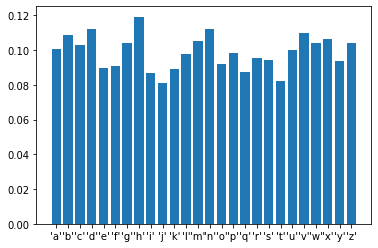

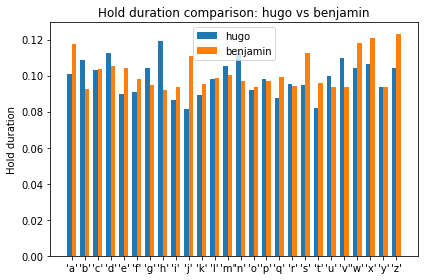

In [9]:
def listAlphabet():
  return list(string.ascii_lowercase)


def getPosa(dataframe):
  
  for i in dataframe.index:
    if dataframe.loc[i, 'Key'] == "\'a\'":
      return i
    
    

def visualize(user_reference):
    user_reference = user_reference.sort_values("Key")
    user_reference = user_reference.reset_index(drop=True)
    user_reference["HD_mean"] = pd.to_numeric(user_reference["HD_mean"], downcast="float")
    a = getPosa(user_reference)
    fig, ax = plt.subplots()
    labels = user_reference.iloc[a:a+26, 0]
    values = user_reference.iloc[a:a+26, 2]
    rect = ax.bar(labels, values)
    fig.show()

def hold_comparison(user, user_bis):
    user_ref = pd.read_csv(path_reference+user+".csv", sep=";", names=columns_ref, encoding = "ISO-8859-1")
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.drop([0])
    user_ref = user_ref.reset_index(drop=True)
    user_ref = user_ref.sort_values("Key")

    user_ref_bis = pd.read_csv(path_reference+user_bis+".csv", sep=";", names=columns_ref, encoding = "ISO-8859-1")
    user_ref_bis = user_ref_bis.reset_index(drop=True)
    user_ref_bis = user_ref_bis.drop([0])
    user_ref_bis = user_ref_bis.reset_index(drop=True)
    user_ref_bis = user_ref_bis.sort_values("Key")
    
    
    user_ref = user_ref.reset_index(drop=True)
    user_ref["HD_mean"] = pd.to_numeric(user_ref["HD_mean"], downcast="float")
    user_ref_bis = user_ref_bis.reset_index(drop=True)
    user_ref_bis["HD_mean"] = pd.to_numeric(user_ref_bis["HD_mean"], downcast="float")
    a = getPosa(user_ref)
    
    a_bis = getPosa(user_ref_bis)

    labels = user_ref.iloc[a:a+26, 0]
    values = user_ref.iloc[a:a+26, 2]
    
    values_bis = user_ref_bis.iloc[a_bis:a_bis+26, 2]
    width = 0.35  # the width of the bars
    x = np.arange(len(labels))
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, values, width, label=user)
    rects2 = ax.bar(x + width/2, values_bis, width, label=user_bis)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Hold duration')
    ax.set_title('Hold duration comparison: '+ user +' vs '+ user_bis)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    

    fig.tight_layout()
    plt.show()
    
hugo = pd.read_csv(path_reference+"hugo.csv", sep=";", names=columns_ref, encoding = "ISO-8859-1")
hugo = hugo.reset_index(drop=True)
hugo = hugo.drop([0])
hugo = hugo.reset_index(drop=True)
hugo = hugo.sort_values("Key")
visualize(hugo)
hold_comparison('hugo', 'benjamin')

In [10]:

def performance_polygon(Username, criterias):
        colors = ["blue", "red", "green", "orange", "brown", "deeppink","sienna",
                "gold", "olivedrab", "mediumspringgreen", "navy", "plum", "cadetblue", "darkmagenta"
                , "black"]
        fig = go.Figure()
        for i in range (0,len(Username)):
            user = pd.read_csv(path_reference+Username[i]+".csv",  sep=";", names=columns_ref, encoding = "ISO-8859-1")
            user = user.reset_index(drop=True)
            user = user.drop([0])
            user = user.reset_index(drop=True)
            user["HD_mean"] = pd.to_numeric(user["HD_mean"], downcast="float")

            user = user.sort_values("Key")
            a = getPosa(user)
            values1 = user.iloc[a:a+26, 2]
            
            fig.add_trace(go.Scatterpolar(
                r=values1,
                theta=criterias,
                name=Username[i]
            ))
        name = ""
        for i in Username:
            name += i + " vs "
        size = len(name)
        name = name[:size - 3]
        fig.update_layout(
            title="Hold Duration : "+ name,
            xaxis_title="x Axis Title",
            yaxis_title="y Axis Title",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )   
        fig.update_layout(title_text="Hold Duration : "+ name, title_x=0.5) 
        fig.show()

            
        

criterias = listAlphabet()
print(criterias)
performance_polygon(["hugo", "benjamin"], criterias)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
